# Talktorial 11 (part A)

# CADD web services that can be used via a Python API

__Developed at AG Volkamer, Charité__

Dr. Jaime Rodríguez-Guerra

## Aim of this talktorial

Web services are a convenient way of using software because it frees the user from any installation hassles. A web UI is usually available for easy usage, at the cost of losing the possibility to automate a workflow. Fortunately, the number of web services that provide an API for automated access has been increasing. Some examples in the field of Computer Aided Drug Design include:

- ChEMBL
- RCSB PDB
- KLIFS
- Proteins.plus
- SwissDock

In this notebook, you will learn how to programmatically use online web-services from Python, always in the context of drug design. The end goal will be to build a full pipeline that exclusively relies on web-services, without (almost) any local execution!

__Note__: For simplicity, the full lesson will be divided in three notebooks:

- 11a. Querying KLIFS & PubChem for potential kinase inhibitors
- 11b. Docking the candidates against the target obtained in 11a
- 11c. Assessing the results and comparing against known data

## Learning goals

### Theory

- Types of programmatic access
- Description of the pipeline and the involved webservices

### Practical

- Building the pipeline
- Case study: EGFR inhibitors

### Discussion

See below.

### Quiz

See below.

***


# Theory

## Types of programmatic access

### Programmatic APIs

Modern webservices are able to provide standardized ways to access their data, especially when it comes to databases. This usually means that you can access a specific URL in their site to request results that are __machine readable__.

For example, [UniProt](https://www.uniprot.org/) is a database for all types of information concerning proteins. If you look for a specific protein, like `Src` (involved in cancer), you will arrive to [this beautiful webpage](https://www.uniprot.org/uniprot/P12931) with well organized content sections. If you add `.fasta` to the URL, however, you will obtain the protein sequence in `FASTA` format.

```
https://www.uniprot.org/uniprot/P12931 -> https://www.uniprot.org/uniprot/P12931.fasta
---

>sp|P12931|SRC_HUMAN Proto-oncogene tyrosine-protein kinase Src OS=Homo sapiens OX=9606 GN=SRC PE=1 SV=3
MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAE
PKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGD
WWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRES
ETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGL
CHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTL
KPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKY
LRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYT
ARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVER
GYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL

```

This is a way to provide programmatic access to a webservice: through specific URL schemes. However, each webservice would have to come up with their own scheme, which will force the developers to implement their scripts on a case-by-case basis.

Fortunately, there are some standardized ways to provide this kind of programmatic access:

- HTTP-based RESTful APIs ([wiki](https://en.wikipedia.org/wiki/Representational_state_transfer#Applied_to_Web_services)).
- GraphQL
- SOAP
- gRPC

In this talktorial, we will only use REST and SOAP APIs.

#### HTTP-based RESTful APIs

This type of programmatic access/provision defines a specific entry point for clients (scripts, libraries, programs) that require programmatic access, something like `api.webservice.com`. They can be versioned, so the provider can update the scheme without disrupting existing implementations (`api.webservice.com/v1` will still work even when `api.webservice.com/v2` has been deployed).

This kind of APIs are usually accompanied by well-written documentation explaining all the available actions in the platform. For example, look at the [GitHub REST API for listing repositories](https://developer.github.com/v3/repos/#list-organization-repositories). You can see how every argument and option is documented, along with usage examples. 

The only difficulty is to build the needed URLs in the correct way:

```
https://api.github.com/users/volkamerlab/repos
```

<details>
    <summary>
        Returns
    </summary>

```
[
  {
    "id": 156864288,
    "node_id": "MDEwOlJlcG9zaXRvcnkxNTY4NjQyODg=",
    "name": "TeachOpenCADD",
    "full_name": "volkamerlab/TeachOpenCADD",
    "private": false,
    "owner": {
      "login": "volkamerlab",
      "id": 44878588,
      "node_id": "MDEyOk9yZ2FuaXphdGlvbjQ0ODc4NTg4",
      "avatar_url": "https://avatars2.githubusercontent.com/u/44878588?v=4",
      "gravatar_id": "",
      "url": "https://api.github.com/users/volkamerlab",
      "html_url": "https://github.com/volkamerlab",
      "followers_url": "https://api.github.com/users/volkamerlab/followers",
      "following_url": "https://api.github.com/users/volkamerlab/following{/other_user}",
      "gists_url": "https://api.github.com/users/volkamerlab/gists{/gist_id}",
      "starred_url": "https://api.github.com/users/volkamerlab/starred{/owner}{/repo}",
      "subscriptions_url": "https://api.github.com/users/volkamerlab/subscriptions",
      "organizations_url": "https://api.github.com/users/volkamerlab/orgs",
      "repos_url": "https://api.github.com/users/volkamerlab/repos",
      "events_url": "https://api.github.com/users/volkamerlab/events{/privacy}",
      "received_events_url": "https://api.github.com/users/volkamerlab/received_events",
      "type": "Organization",
      "site_admin": false
    },
    "html_url": "https://github.com/volkamerlab/TeachOpenCADD",
    "description": "TeachOpenCADD: a teaching platform for computer-aided drug design (CADD) using open source packages and data",
    "fork": false,
    "url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD",
    "forks_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/forks",
    "keys_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/keys{/key_id}",
    "collaborators_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/collaborators{/collaborator}",
    "teams_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/teams",
    "hooks_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/hooks",
    "issue_events_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/issues/events{/number}",
    "events_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/events",
    "assignees_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/assignees{/user}",
    "branches_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/branches{/branch}",
    "tags_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/tags",
    "blobs_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/blobs{/sha}",
    "git_tags_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/tags{/sha}",
    "git_refs_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/refs{/sha}",
    "trees_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/trees{/sha}",
    "statuses_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/statuses/{sha}",
    "languages_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/languages",
    "stargazers_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/stargazers",
    "contributors_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/contributors",
    "subscribers_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/subscribers",
    "subscription_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/subscription",
    "commits_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/commits{/sha}",
    "git_commits_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/commits{/sha}",
    "comments_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/comments{/number}",
    "issue_comment_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/issues/comments{/number}",
    "contents_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/contents/{+path}",
    "compare_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/compare/{base}...{head}",
    "merges_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/merges",
    "archive_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/{archive_format}{/ref}",
    "downloads_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/downloads",
    "issues_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/issues{/number}",
    "pulls_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/pulls{/number}",
    "milestones_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/milestones{/number}",
    "notifications_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/notifications{?since,all,participating}",
    "labels_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/labels{/name}",
    "releases_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/releases{/id}",
    "deployments_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/deployments",
    "created_at": "2018-11-09T13:15:15Z",
    "updated_at": "2019-07-18T02:36:48Z",
    "pushed_at": "2019-05-03T15:02:03Z",
    "git_url": "git://github.com/volkamerlab/TeachOpenCADD.git",
    "ssh_url": "git@github.com:volkamerlab/TeachOpenCADD.git",
    "clone_url": "https://github.com/volkamerlab/TeachOpenCADD.git",
    "svn_url": "https://github.com/volkamerlab/TeachOpenCADD",
    "homepage": null,
    "size": 28121,
    "stargazers_count": 39,
    "watchers_count": 39,
    "language": "Jupyter Notebook",
    "has_issues": true,
    "has_projects": true,
    "has_downloads": true,
    "has_wiki": true,
    "has_pages": false,
    "forks_count": 13,
    "mirror_url": null,
    "archived": false,
    "disabled": false,
    "open_issues_count": 0,
    "license": {
      "key": "cc-by-4.0",
      "name": "Creative Commons Attribution 4.0 International",
      "spdx_id": "CC-BY-4.0",
      "url": "https://api.github.com/licenses/cc-by-4.0",
      "node_id": "MDc6TGljZW5zZTI1"
    },
    "forks": 13,
    "open_issues": 0,
    "watchers": 39,
    "default_branch": "master"
  }
]
```
</details>

, which happens to be a [JSON](https://en.wikipedia.org/wiki/JSON)-formatted dictionary! This is easily parsed into a Python dictionary using the `json` library. The best news is that you don't even need that. Using `requests`, the following operation can be done in three lines:

In [1]:
import requests

response = requests.get("https://api.github.com/users/volkamerlab/repos")
response.raise_for_status()
result = response.json()
result

[{'id': 156864288,
  'node_id': 'MDEwOlJlcG9zaXRvcnkxNTY4NjQyODg=',
  'name': 'TeachOpenCADD',
  'full_name': 'volkamerlab/TeachOpenCADD',
  'private': False,
  'owner': {'login': 'volkamerlab',
   'id': 44878588,
   'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0ODc4NTg4',
   'avatar_url': 'https://avatars2.githubusercontent.com/u/44878588?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/volkamerlab',
   'html_url': 'https://github.com/volkamerlab',
   'followers_url': 'https://api.github.com/users/volkamerlab/followers',
   'following_url': 'https://api.github.com/users/volkamerlab/following{/other_user}',
   'gists_url': 'https://api.github.com/users/volkamerlab/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/volkamerlab/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/volkamerlab/subscriptions',
   'organizations_url': 'https://api.github.com/users/volkamerlab/orgs',
   'repos_url': 'https://api.github.com/users/volkamerlab/re

If you parameterize the URL with an `f-string`, then you can design a function that will list the repositories of any user:

In [2]:
def repos(username):
    response = requests.get(f"https://api.github.com/users/{username}/repos")
    response.raise_for_status()
    return response.json()

repos("volkamerlab")

[{'id': 156864288,
  'node_id': 'MDEwOlJlcG9zaXRvcnkxNTY4NjQyODg=',
  'name': 'TeachOpenCADD',
  'full_name': 'volkamerlab/TeachOpenCADD',
  'private': False,
  'owner': {'login': 'volkamerlab',
   'id': 44878588,
   'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0ODc4NTg4',
   'avatar_url': 'https://avatars2.githubusercontent.com/u/44878588?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/volkamerlab',
   'html_url': 'https://github.com/volkamerlab',
   'followers_url': 'https://api.github.com/users/volkamerlab/followers',
   'following_url': 'https://api.github.com/users/volkamerlab/following{/other_user}',
   'gists_url': 'https://api.github.com/users/volkamerlab/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/volkamerlab/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/volkamerlab/subscriptions',
   'organizations_url': 'https://api.github.com/users/volkamerlab/orgs',
   'repos_url': 'https://api.github.com/users/volkamerlab/re

#### Generating a client for any API

Did you find that convenient? Well, we are not done yet!

The REST API schema can be expressed programmatically in a document called [Swagger/OpenAPI definitions](https://swagger.io/docs/specification/about/), which allows to dynamically generate a Python client for any REST API that implements the Swagger/OpenAPI schema. [This the one for GitHub](https://api.apis.guru/v2/specs/github.com/v3/swagger.json).

Of course, there are libraries for doing that in Python:

- `bravado`
- `agithub`

Using Bravado:

In [3]:
from bravado.client import SwaggerClient
GITHUB_SWAGGER = "https://api.apis.guru/v2/specs/github.com/v3/swagger.json"
client = SwaggerClient.from_url(GITHUB_SWAGGER)
client

SwaggerClient(https://api.github.com/)

Then, you can have fun inspecting the `client` object for all the API actions as methods. We will see an actual example with [KLIFS](http://klifs.vu-compmedchem.nl) in the case study.

__Tip__: Use `client?` to inspect the client in this Notebook.

Other standards like SOAP operate on a very similar principle: all you need to provide is a definition file to be processed by a client-generating library. For SOAP, the definition files are formatted as `.wsdl`. One of the most popular libraries is `suds` (now installable as `suds-community`).

In [4]:
import suds.client
wsdl = 'http://www.swissdock.ch/soap/wsdl'
client = suds.client.Client(wsdl)
# Suds does not populate the __docstring__ (accessed via ?), but overloads the __str__() method
# In other words, you have to "print" the object to get the documentation
print(client)


Suds ( https://fedorahosted.org/suds/ )  version: 0.8.3

Service ( SwissdockInterfaceWrapper ) tns="http://swissdock.vital-it.ch/soap/"
   Prefixes (1)
      ns0 = "http://swissdock.vital-it.ch/soap/"
   Ports (1):
      (SwissdockInterfaceWrapper)
         Methods (21):
            forget(xs:string jobID)
            getNewDockingPool()
            getPredictedDocking(xs:string jobID)
            getPredictedDockingAllFiles(xs:string jobID)
            getPredictedDockingFile(xs:string jobID, xs:string filename)
            getPredictedDockingPool(xs:string dockingPoolID, xs:boolean mergedock4)
            getPredictedDockingPoolFile(xs:string dockingPoolID, xs:string filename)
            getPreparedLigand(xs:string jobID)
            getPreparedTarget(xs:string jobID)
            isDockingKnown(xs:string jobID)
            isDockingPoolKnown(xs:string jobID)
            isDockingPoolRunning(xs:string currentPoolID)
            isDockingPoolTerminated(xs:string currentPoolID)
      

### Document parsing

Sometimes you won't be as lucky and the webservice won't provide a standardized API that produces machine-readable documents. Instead, you will have to use the regular webpage and parse through the HTML code to obtain the information you need. This is called (web) __scraping__, which usually involves finding the right HTML tags and IDs that contain the valuable data (ignoring things such as the sidebars, top menus, footers, ads, etc).

In scraping, you basically do two things:

1. Access the webpage with `requests` and obtain the HTML contents.
2. Parse the HTML string with `BeautifulSoup` or `requests-html`.


Let's parse the proteinogenic amino acids table in this [Wikipedia article](https://en.wikipedia.org/wiki/Proteinogenic_amino_acid):

In [50]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

r = requests.get("https://en.wikipedia.org/wiki/Proteinogenic_amino_acid")
r.raise_for_status()

# To guess the correct steps here, you will have to inspect the HTML code by hand
# Tip: use right-click + inspect content in any webpage to land in the HTML definition ;)
html = BeautifulSoup(r.text)
header = html.find('span', id="General_chemical_properties")
table = header.find_all_next()[4]
table_body = table.find('tbody')

data = []
for row in table_body.find_all('tr'):
    cells = row.find_all('td')
    if cells:
        data.append([])
    for cell in cells:
        cell_content = cell.text.strip()
        try:  # convert to float if possible
            cell_content = float(cell_content)
        except ValueError:
            pass
        data[-1].append(cell_content)
pd.DataFrame.from_records(data)

,0,1,2,3,4,5
0,A,Ala,89.09404,6.01,2.35,9.87
1,C,Cys,121.15404,5.05,1.92,10.7
2,D,Asp,133.10384,2.85,1.99,9.9
3,E,Glu,147.13074,3.15,2.1,9.47
4,F,Phe,165.19184,5.49,2.2,9.31
5,G,Gly,75.06714,6.06,2.35,9.78
6,H,His,155.15634,7.6,1.8,9.33
7,I,Ile,131.17464,6.05,2.32,9.76
8,K,Lys,146.18934,9.6,2.16,9.06
9,L,Leu,131.17464,6.01,2.33,9.74


### Browser remote control

The trend some years ago was to build servers that dynamically-generated HTML document with some JavaScript here and there (such as Wikipedia). In other words, the HTML is built in the server and sent to the client (your browser).

However, latest trends are pointing towards full applications built entirely with JavaScript frameworks. This means that the HTML content is dynamically generated in the client, so traditional parsing won't work: you will only download placeholder HTML to host the JavaScript framework. To work around this, the HTML must be rendered with a client-side JavaScript engine.

We won't cover this in this notebook, but you can check these projects if you are interested:

- [puppeteer](https://github.com/GoogleChrome/puppeteer)
- [selenium](https://www.seleniumhq.org/)


***

## Description of the pipeline and the involved webservices


1. KLIFS will provide protein-ligand pairs that are known to interact with each other.  We can obtain the curated protein structure from this database and use the ligand information to retrieve similar ligands from other databases, like PubChem or ChEMBL.
2. Using the ligand information provided by KLIFS, we can query PubChem for similar compounds.
3. After having obtained the protein structure(s) and several candidate ligands, we can dock them online with the Vina installation provided in the OPAL web services. We will also query _proteins.plus'_ DoGSiteScorer for probable binding sites where we will dock the compounds. (part B)
4. The results will be visualized with `nglview` and their interactions fingerprints compared with those provided originally in KLIFS. (part C)

In this part (A) of the talktorial, we will obtain input kinase-inhibitor structures from the _KLIFS_ database and query _PubChem_ for similar compounds that could be tested as potential inhibitors. Relevant output will be written to disk at `data/` so we can use it later on.

### KLIFS

* Role: Kinase-ligand interaction profiles database
* Website: http://klifs.vu-compmedchem.nl/
* API: Yes, REST-based, Swagger-enabled. No official client. Use `bravado`.
* Documentation: http://klifs.vu-compmedchem.nl/swagger/
* Literature:
    * Nucleic Acids Research, 2016, 44, D1, 6,  D365–D371, https://doi.org/10.1093/nar/gkv1082
    * J. Med. Chem. 2014, 57, 2, 249-277. https://pubs.acs.org/doi/abs/10.1021/jm400378w
    

> Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that revolves around the protein structure of catalytic kinase domains and the way kinase inhibitors can interact with them. Based on the underlying systematic and consistent protocol all (currently human and mouse) kinase structures and the binding mode of kinase ligands can be directly compared to each other. Moreover, because of the classification of an all-encompassing binding site of 85 residues it is possible to compare the interaction patterns of kinase-inhibitors to each other to, for example, identify crucial interactions determining kinase-inhibitor selectivity.

### PubChem

* Role: Small compounds database
* Website: https://pubchem.ncbi.nlm.nih.gov/
* API: Yes, REST-based. No official client. Use `bravado`.
* Documentation: https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest
* Literature:
    * Nucleic Acids Res. 2019 Jan 8; 47(D1):D1102-1109. https://academic.oup.com/nar/article/47/D1/D1102/5146201

> PubChem is an open chemistry database at the National Institutes of Health (NIH). “Open” means that you can put your scientific data in PubChem and that others may use it. Since the launch in 2004, PubChem has become a key chemical information resource for scientists, students, and the general public. Each month our website and programmatic services provide data to several million users worldwide.



***

# Practical

## Building the pipeline

### Obtaining information from KLIFS

Choose a random kinase from the EGFR family (in `mol2`) and the corresponding ligands (`SMILES`) from the KLIFS database. We will also obtain the PDB structure of the protein-ligand complex so we can calculate the binding pockets in part B.

In [9]:
from bravado.client import SwaggerClient
KLIFS_API_DEFINITIONS = "http://klifs.vu-compmedchem.nl/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={'validate_responses': False})

In [10]:
def _all_kinase_families():
    return KLIFS_CLIENT.Information.get_kinase_families().response().result

def _kinases_from_family(family, species="HUMAN"):
    return KLIFS_CLIENT.Information.get_kinase_names(kinase_family=family, species=species).response().result

def _protein_and_ligand_structure(*kinase_ids):
    structures = KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=kinase_ids).response().result
    molcomplex = KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(structure_ID=structures[0].structure_ID).response().result
    protein = KLIFS_CLIENT.Structures.get_structure_get_protein(structure_ID=structures[0].structure_ID).response().result
    ligands = KLIFS_CLIENT.Ligands.get_ligands_list(kinase_ID=kinase_ids).response().result
    return molcomplex, protein, [ligand.SMILES for ligand in ligands]

In [12]:
import random
import time
def step_01_random():
    # Get a random kinase from a random family
    attempts = 20
    families = _all_kinase_families()
    while attempts:  # some kinase IDs cannot be found in the structure list...
        family = random.choice(families)
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:                   
            print("Chosen", kinase.name, "kinase with ID", kinase.kinase_ID, "from family", family)
            return molcomplex, protein, ligands
    print("Could not find a valid kinase. Try again!")
    return None, None, None


def step_01(family):
    """
    Given a kinase family name (check `_all_kinase_families()`), retrieve a random structure.
    """
    attempts = 20
    while attempts:  # some kinase IDs cannot be found in the structure list...
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:                   
            print("Chosen", kinase.name, "kinase with ID", kinase.kinase_ID, "from family", family)
            return molcomplex, protein, ligands
    print("Could not find a valid kinase. Try again!")
    return None, None, None

Let's check if this works. Let's say you want a random kinase from a random family, you can use `step_01_random()` like this:

In [13]:
molcomplex, protein, ligands = step_01_random()

Chosen CAMK1D kinase with ID 110 from family CAMK1


In [14]:
ligands

['n1c(nc2c(c1NC3=NNC(=C3)C)cccc2)c4ccccc4']

Let's preview the protein with `nglview` and the ligands with `rdkit`.

In [38]:
import nglview as nv
from tempfile import NamedTemporaryFile
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage #Needed to show molecules

def preview_molecule_contents(contents):
    # This is a temporary file, it will be autodeleted
    with NamedTemporaryFile('w+', suffix='.mol2') as f:
        f.write(protein)
        v = nv.show_file(f.name)
    return v

def preview_smiles(smiles):
    print(smiles)
    return Chem.MolFromSmiles(ligands[0])

def multi_preview_smiles(*smiles):
    legends = [f"{s[:30]}..." for s in smiles]  # shorten the smiles string to avoid text overlap
    molecules = [Chem.MolFromSmiles(s) for s in smiles]
    return MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300), maxMols=len(rdkit_ligands),
                           legends=legends, useSVG=True)

In [31]:
preview_molecule_contents(protein)

NGLWidget()

n1c(nc2c(c1NC3=NNC(=C3)C)cccc2)c4ccccc4


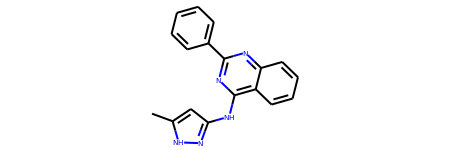

In [37]:
preview_smiles(ligands[0])

### Query ChEMBL and PubChem

Use the previously obtained `SMILES` string to query similar compounds in PubChem.

In [23]:
import requests
def similar_compounds_pubchem(smiles, threshold=75, n_records=10):
    # Query PubChem for similar compounds
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()['Waiting']['ListKey']
    # Response is async, poll every second for 25 seconds to see if it's done
    attempts = 25
    while attempts:
        r = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON")
        r.raise_for_status()
        response = r.json()
        if 'IdentifierList' in response:
            cids = response['IdentifierList']['CID']
            break
        attempts -= 1
        time.sleep(1)
    else:
        raise IOError("Could not find matches for " + smiles)
    # We get the Compound IDs back, but we need the SMILES
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item['CanonicalSMILES'] for item in r.json()['PropertyTable']['Properties']]

In [39]:
def step_02(ligands):
    # Get the first ligand for the current kinase
    smiles = ligands[0]
    # Look for 10 most similar compounds on pubchem
    return similar_compounds_pubchem(smiles, n_records=10)


Draw the obtained compounds with RDkit

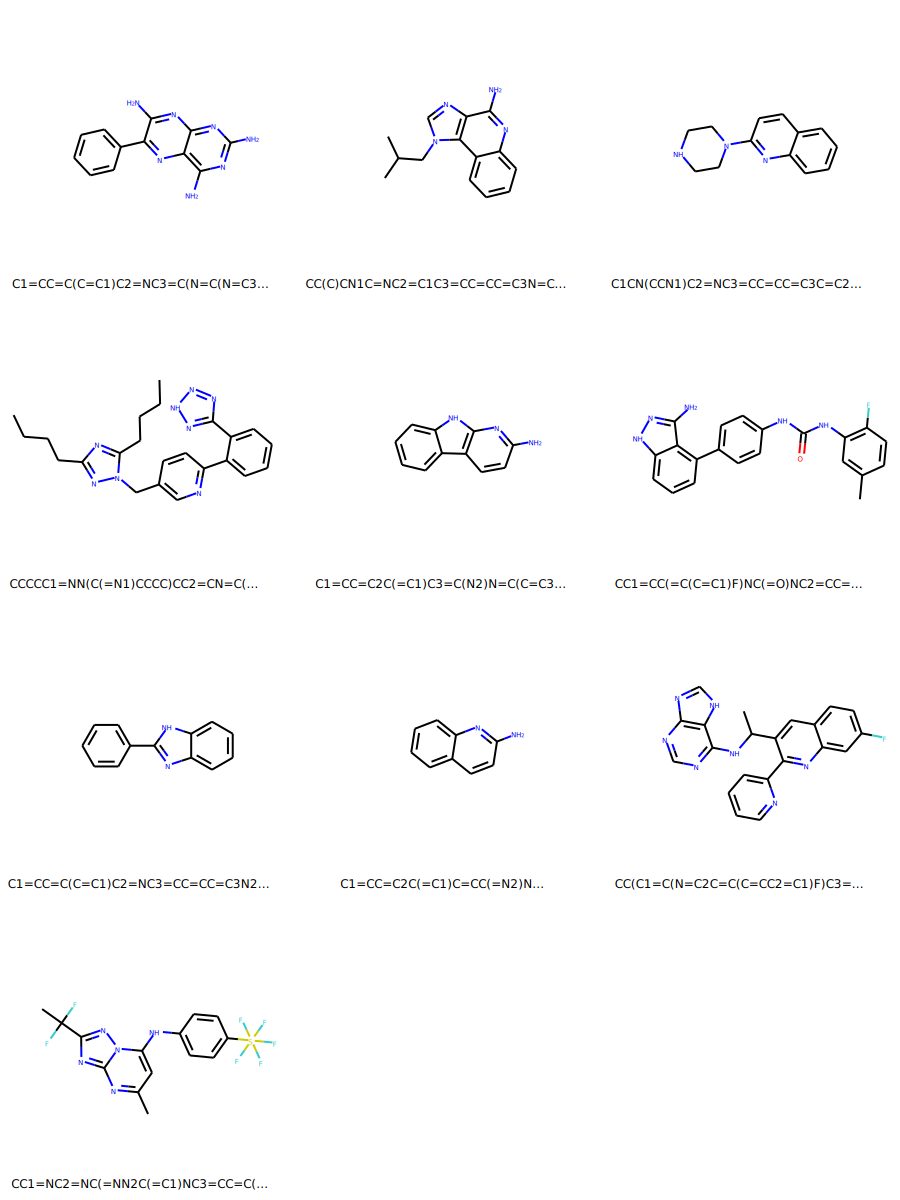

In [40]:
similar_smiles = step_02(ligands)
multi_preview_smiles(*similar_smiles)

## Case study: EGFR

Adapted from [the corresponding Wikipedia article](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor):

>The epidermal growth factor receptor (EGFR) is a member of the ErbB family of receptors, a subfamily of four closely related receptor tyrosine kinases: EGFR (ErbB-1), HER2/neu (ErbB-2), Her 3 (ErbB-3) and Her 4 (ErbB-4). In many cancer types, mutations affecting EGFR expression or activity could result in cancer.
>
>Deficient signaling of the EGFR and other receptor tyrosine kinases in humans is associated with diseases such as Alzheimer's, while over-expression is associated with the development of a wide variety of tumors. Interruption of EGFR signalling, either by blocking EGFR binding sites on the extracellular domain of the receptor or by inhibiting intracellular tyrosine kinase activity, can prevent the growth of EGFR-expressing tumours and improve the patient's condition.


As a result, we are interested in finding potential inhibitors that can target members of the EGFR family. Let's repeat the same steps as above, but now targetting this specific family.

In [44]:
egfr_molcomplex, egfr_protein, egfr_ligands = step_01('EGFR')
similar_smiles_egfr = step_02(egfr_ligands)

Chosen ERBB4 kinase with ID 409 from family EGFR


Preview protein

In [45]:
preview_molecule_contents(egfr_protein)

NGLWidget()

Preview EGFR ligand (ATP)

Clc1c(OCc2cc(F)ccc2)ccc(Nc3ncnc4c3cc(cc4)C=5OC(=CC5)CNCCS(=O)(=O)C)c1


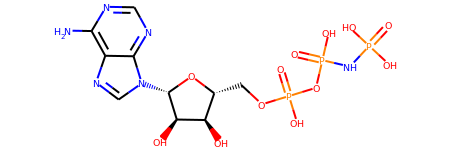

In [48]:
preview_smiles(egfr_ligands[0])

Preview similar ligands

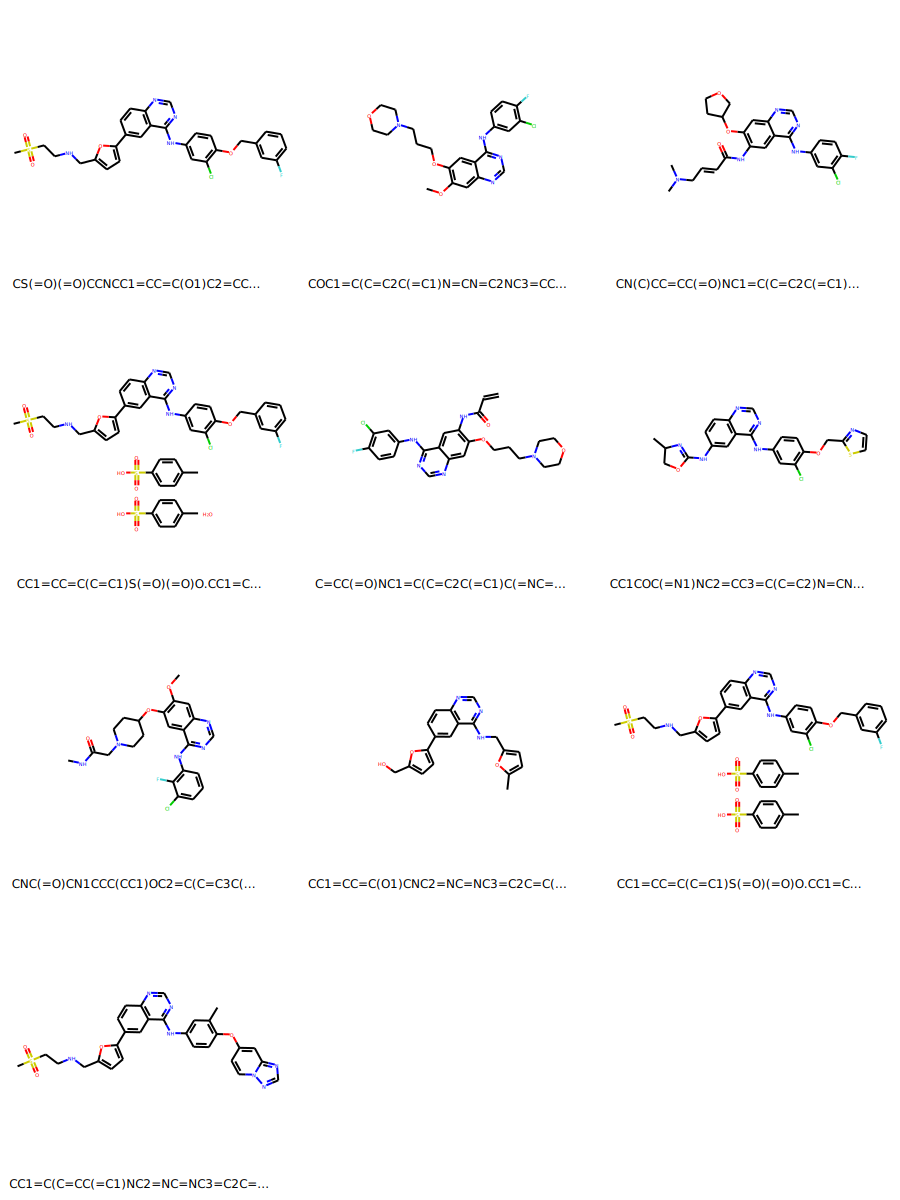

In [47]:
multi_preview_smiles(*similar_smiles_egfr)

Write results to disk for the next part of the talktorial!

In [49]:
import os
os.makedirs('data', exist_ok=True)
with open('data/similar_smiles.txt', 'w') as f:
    f.write('\n'.join(similar_smiles_egfr))
with open('data/protein.mol2', 'w') as f:
    f.write(egfr_protein)
with open('data/complex.pdb', 'w') as f:
    f.write(egfr_molcomplex)

***

# Discussion

In this notebook you have learned how to access and use different web services depending on the technologies available, from well documented API to handcrafter scrapers that try to mimic an actual web browser.

So far, we have queried the KLIFS database for members of the EGFR family, obtaining a kinase structure plus (unsurprisingly) its native ligand, the ATP. Then, PubChem has provided similar compounds with more than a 75% of similarity. Of those, we will choose one to perform structural modeling.


***

# Quiz

- How many kinases does KLIFS provide for the "EGFR" family?
- Can you make the similarity search more strict?
- Is any of the proposed candidates already an approved inhibitor? (Hint: You can _scrape_ [PKIDB](http://www.icoa.fr/pkidb/) and check against the list of smiles)